In [1]:

import os
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
%matplotlib inline

In [60]:


# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [61]:
df = pd.read_csv('timeseries.csv')
season = {'Winter':1,'Spring':2,'Summer':3,'Autumn':4}

In [62]:
df = df[:96431:]
df.index = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df['G(i)'] = pd.to_numeric(df['G(i)'], errors='coerce')

day  = 60 * 60 * 24
year =  365.2425 * day
month = 30 * day

df["Seconds"] = df.index.map(pd.Timestamp.timestamp)
df ["day sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /day))
df ["day cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /day))
# df ["year sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /year))
# df ["year cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /year))

# 1971
df = df.drop(["Seconds"], axis = 1)

# Check for any NaN values after conversion
# print("NaN values in G(i):", df['G(i)'].isna().sum())
df= df[df['G(i)'] > 10]

def get_season(month):
    if month in [12, 1, 2]:
        return season['Winter']
    elif month in [3, 4, 5]:
        return season['Spring']
    elif month in [6, 7, 8]:
        return season['Summer']
    elif month in [9, 10, 11]:
        return season['Autumn']

# Apply the function to create the season column
df['Season'] = df.index.month.map(get_season)

# Load data into DataFrame
data = df.copy()
data.drop(['Int'], axis = 1,inplace=True)

# Ensure 'time' column is of string type
data['time'] = data['time'].astype(str)

# Validate 'time' column format and filter rows with valid datetime-like strings
valid_time_format = r'^\d{8}:\d{4}$'
data = data[data['time'].str.match(valid_time_format, na=False)]

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Set 'time' as the index
data.set_index('time', inplace=True)

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# print(data.describe())

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Display the first few rows and basic statistics to confirm
# print(scaled_df.head())


print(scaled_df.head(15))
data=scaled_df


                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:07:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:07:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:07:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:07:00  0.854851  0.534190  0.516846  0.273476  0.913663   
2010-01-01 09:07:00  0.895757  0.588417  0.553317  0.204283  0.818074   
2010-01-01 10:07:00  0.864754  0.578904  0.595693  0.125206  0.695461   
2010-01-01 11:07:00  0.766906  0.509335  0.616534  0.046129  0.554181   
2010-01-01 12:07:00  0.605511  0.398621  0.623480  0.034596  0.403861   
2010-01-01 13:07:00  0.404155  0.264479  0.613407  0.079077  0.254745   
2010-01-01 14:07:00  0.173677  0.116899  0.589788  0.102142  0.116995   
2010-01-02 04:07:00  0.006421  0.005470  0.146231  

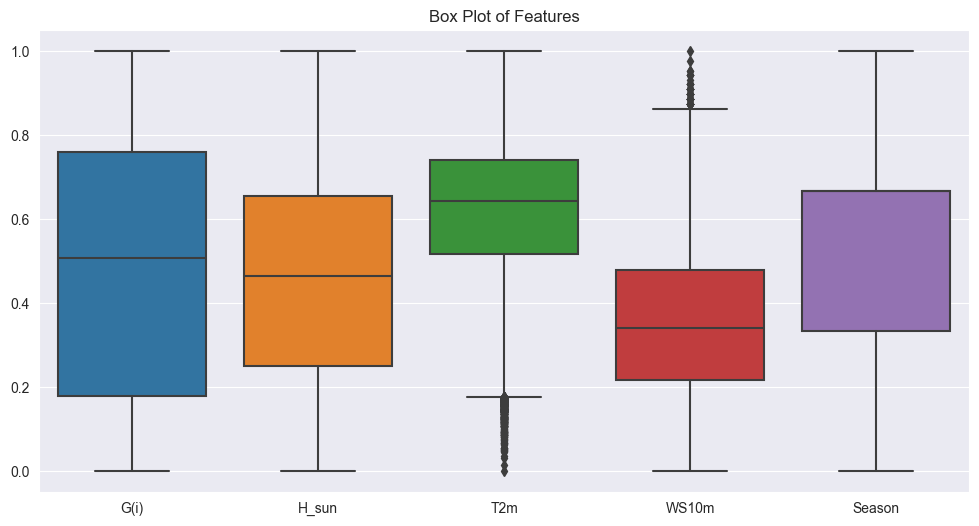

In [63]:
# Box Plots
data_box=data.copy()
data_box.drop(['day sin','day cos'], axis=1,inplace=True)
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_box)
plt.title('Box Plot of Features')
plt.show()

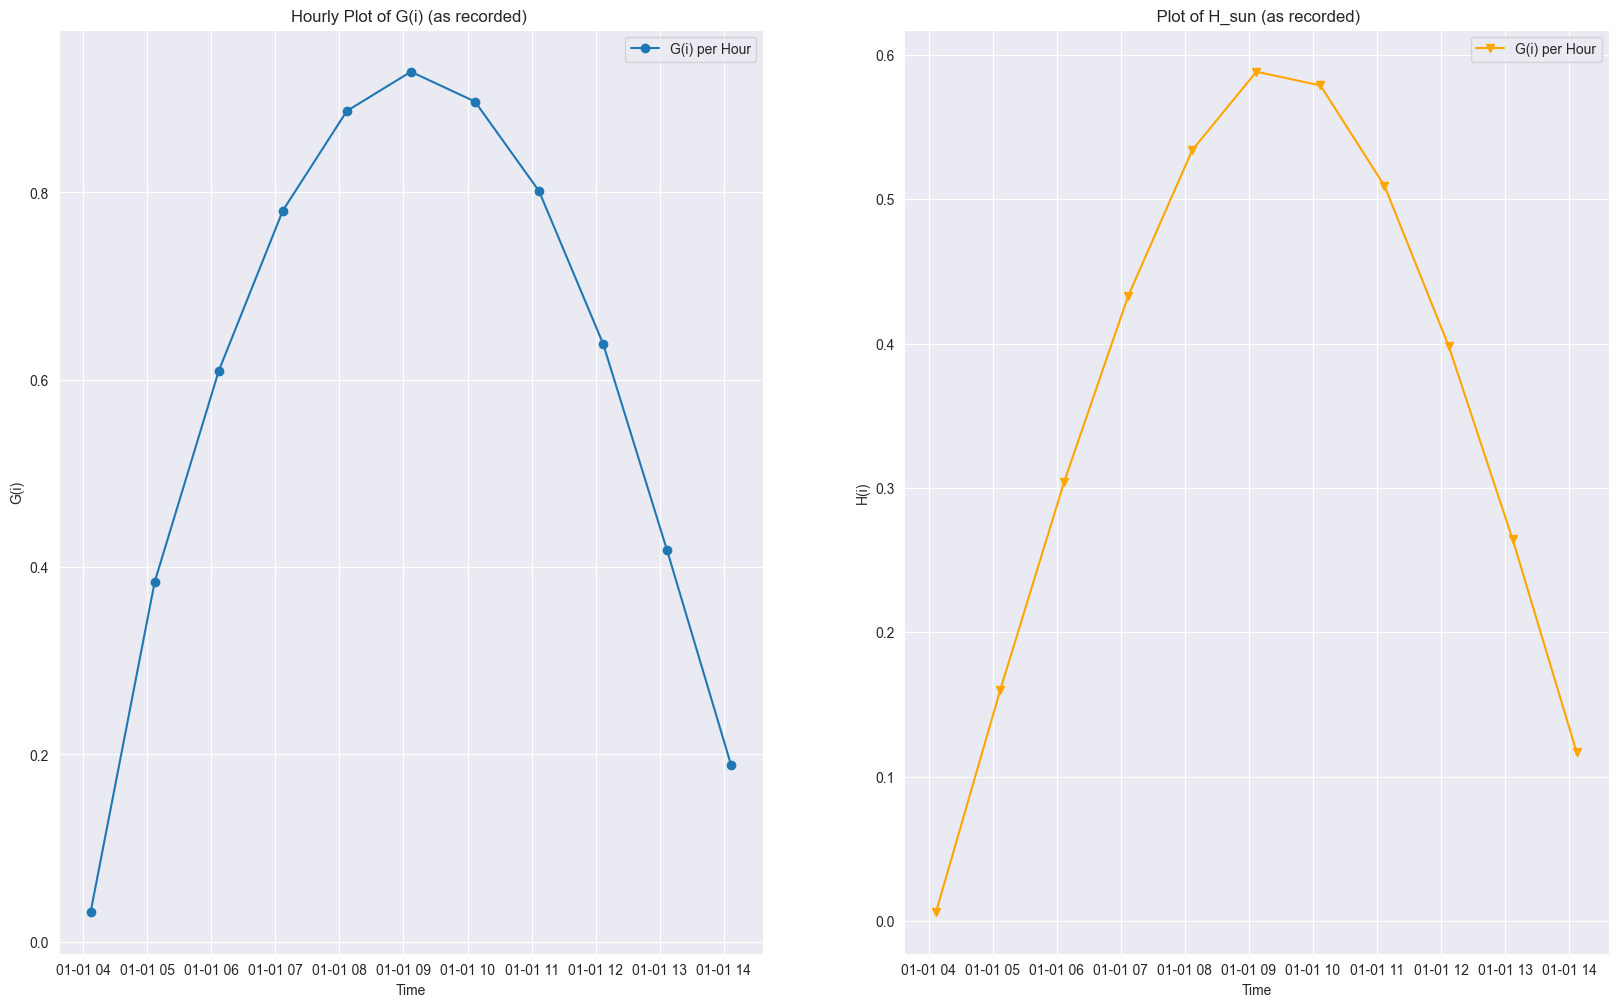

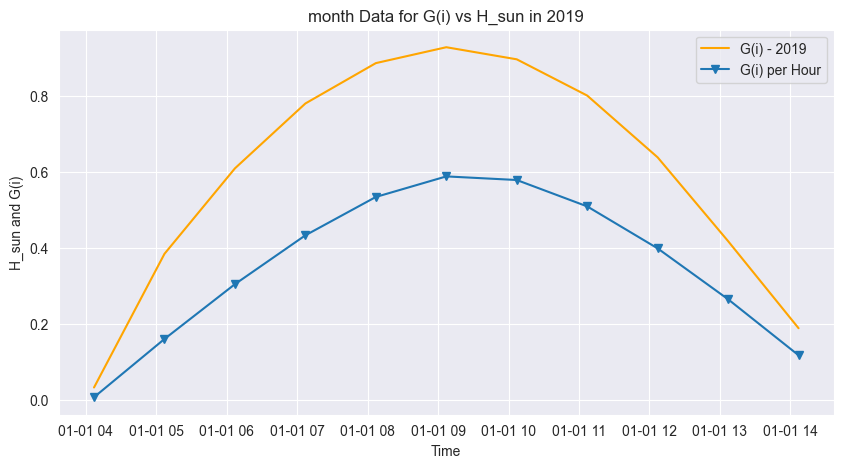

In [64]:
# TODO Merhawi
# this for hourly basis
# Now resample to hourly intervals
# Verify index is DatetimeIndex
data_hourly=data.copy()


data_2019_M1_D1= data_hourly[(data_hourly.index.year == 2019) & (data_hourly.index.month == 1) &
                        (data_hourly.index.day == 1)]



data_2019= data_hourly[(data_hourly.index.year == 2019) & (data_hourly.index.month == 12)]

plt.figure(figsize=(20, 12))
plt.subplot(1,2,1)
plt.plot(data_2019_M1_D1.index, data_2019_M1_D1['G(i)'], marker='o', label='G(i) per Hour')
plt.xlabel('Time')
plt.ylabel('G(i)')
plt.title('Hourly Plot of G(i) (as recorded) ')
plt.legend()

plt.subplot(1,2,2)
plt.plot(data_2019_M1_D1.index, data_2019_M1_D1['H_sun'], marker='v',color='orange' ,label='G(i) per Hour')
plt.xlabel('Time')
plt.ylabel('H(i)')
plt.title(' Plot of H_sun (as recorded)')
plt.legend()

plt.show()
  
  

plt.figure(figsize=(10, 5))
plt.plot(data_2019_M1_D1.index, data_2019_M1_D1['G(i)'], color='orange', label='G(i) - 2019')
plt.plot(data_2019_M1_D1.index, data_2019_M1_D1['H_sun'], marker='v', label='G(i) per Hour')
plt.title('month Data for G(i) vs H_sun in 2019')
plt.xlabel('Time')
plt.ylabel('H_sun and G(i)')
plt.legend()
plt.show()

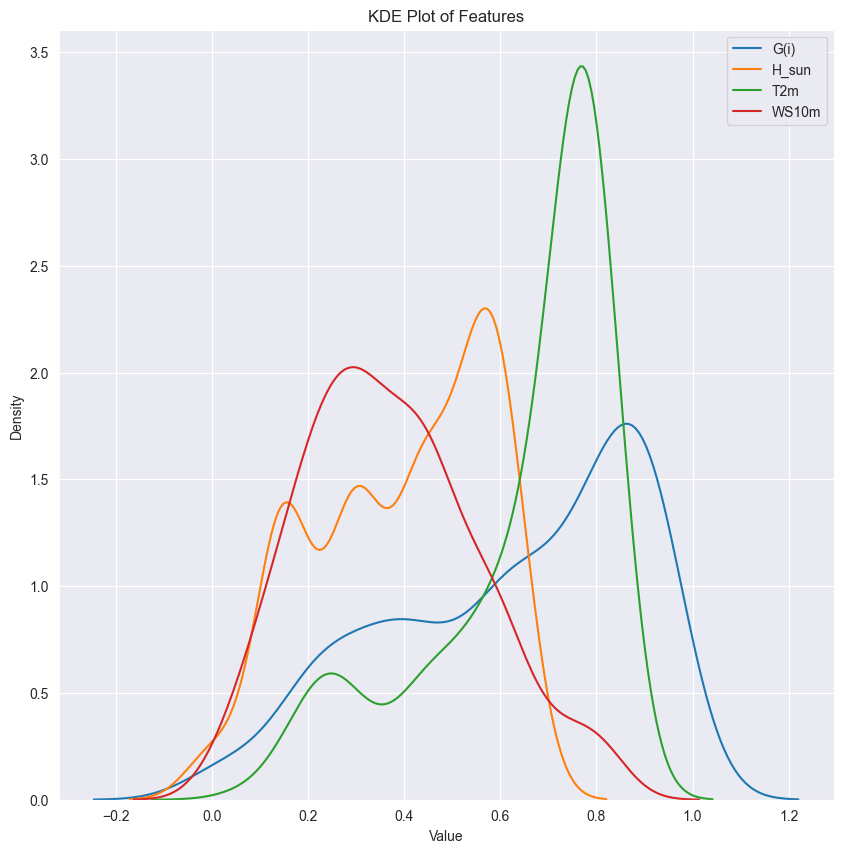

In [65]:
data_2019_M1=data.copy()


data_2019_M1.drop(['Season','day cos', 'day sin'], axis=1, inplace=True)
data_2019_M1 = data_2019_M1[(data.index.year == 2019) & (data.index.month == 1)]
# Additional KDE Plot for each feature to observe distribution
plt.figure(figsize=(10, 10))
for column in data_2019_M1.columns:
    sns.kdeplot(data_2019_M1[column] , label=column)
plt.title('KDE Plot of Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


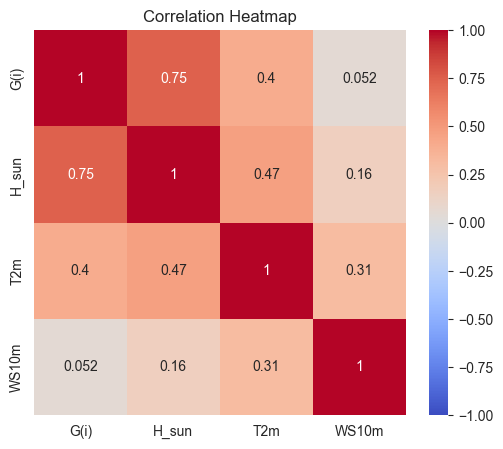

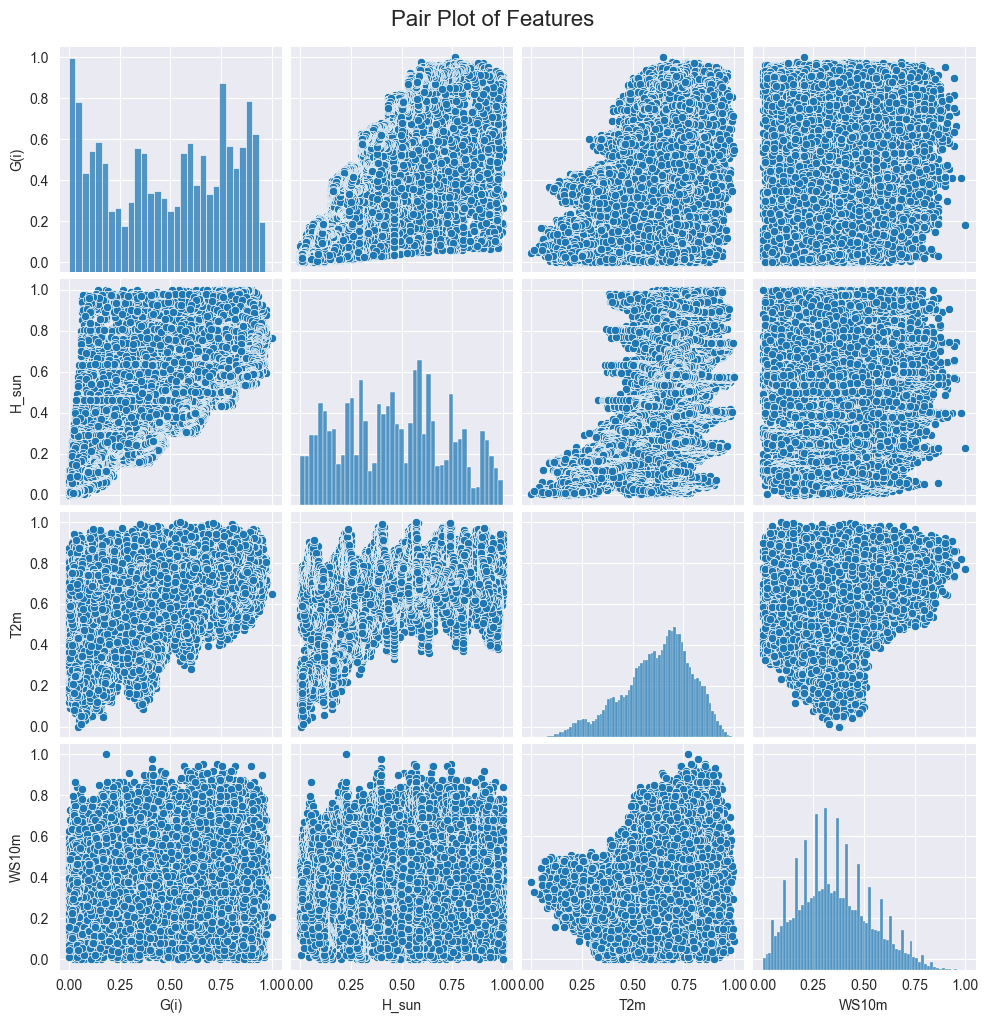

In [66]:
 ## Correlation Analysis
# Correlation Heatmap

data.drop(['day sin','day cos','Season'],axis=1,inplace=True)
plt.figure(figsize=(6, 5))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pair Plot for Visualizing Relationships Between Features
sns.pairplot(data, palette='bright')
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()


In [67]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)

time
2020-12-30 06:07:00    20201230:0607
2020-12-30 07:07:00    20201230:0707
2020-12-30 08:07:00    20201230:0807
2020-12-30 09:07:00    20201230:0907
2020-12-30 10:07:00    20201230:1007
2020-12-30 11:07:00    20201230:1107
2020-12-30 12:07:00    20201230:1207
2020-12-30 13:07:00    20201230:1307
2020-12-30 14:07:00    20201230:1407
2020-12-31 04:07:00    20201231:0407
2020-12-31 05:07:00    20201231:0507
2020-12-31 06:07:00    20201231:0607
2020-12-31 07:07:00    20201231:0707
2020-12-31 08:07:00    20201231:0807
2020-12-31 09:07:00    20201231:0907
2020-12-31 10:07:00    20201231:1007
2020-12-31 11:07:00    20201231:1107
2020-12-31 12:07:00    20201231:1207
2020-12-31 13:07:00    20201231:1307
2020-12-31 14:07:00    20201231:1407
Name: time, dtype: object

In [68]:
df = df[:96431:]  # Truncate the DataFrame to include only the first 96,431 rows.

df.drop(['Int', 'time'], axis = 1,inplace=True)
df_multi = df.iloc[:,:]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


                        G(i)  H_sun    T2m  WS10m   day sin   day cos  Season
time                                                                         
2010-01-01 04:07:00    91.98   2.76   9.77   1.93  0.880891  0.473320       1
2010-01-01 05:07:00   432.28  15.67  11.48   1.72  0.973379  0.229200       1
2010-01-01 06:07:00   681.34  27.82  15.42   1.72  0.999534 -0.030539       1
2010-01-01 07:07:00   867.69  38.65  19.13   1.72  0.957571 -0.288196       1
2010-01-01 08:07:00   987.62  47.15  21.08   1.66  0.850352 -0.526214       1
2010-01-01 09:07:00  1034.38  51.71  22.13   1.24  0.685183 -0.728371       1
2010-01-01 10:07:00   998.94  50.91  23.35   0.76  0.473320 -0.880891       1
2010-01-01 11:07:00   887.09  45.06  23.95   0.28  0.229200 -0.973379       1
2010-01-01 12:07:00   702.60  35.75  24.15   0.21 -0.030539 -0.999534       1
2010-01-01 13:07:00   472.43  24.47  23.86   0.48 -0.288196 -0.957571       1
G(i)       float64
H_sun      float64
T2m        float64
WS10m  

In [69]:
# ToDo Merhawi Check the result by using MinMaxScaler() 
# Initialize MinMaxScaler
scaler = MinMaxScaler() 

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=df_multi.columns, index=df_multi.index)

# Display the first few rows and basic statistics to confirm
print(scaled_df.head())

                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:07:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:07:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:07:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:07:00  0.854851  0.534190  0.516846  0.273476  0.913663   

                      day cos  Season  
time                                   
2010-01-01 04:07:00  1.000000     0.0  
2010-01-01 05:07:00  0.834254     0.0  
2010-01-01 06:07:00  0.657903     0.0  
2010-01-01 07:07:00  0.482966     0.0  
2010-01-01 08:07:00  0.321362     0.0  


In [70]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [71]:
WINDOW_SIZE = 5
df_scaled = scaled_df.to_numpy()
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("#############################")
print(y1[0])
X1.shape, y1.shape

[[0.07133234 0.00630277 0.12400139 0.31795717 0.93133715 1.
  0.        ]
 [0.36903158 0.15982875 0.18339701 0.28336079 0.98486355 0.83425418
  0.        ]
 [0.58691278 0.3043168  0.32025009 0.28336079 1.         0.65790334
  0.        ]
 [0.74993439 0.43310738 0.44911428 0.28336079 0.97571496 0.48296551
  0.        ]
 [0.85485084 0.53418956 0.51684613 0.27347611 0.91366342 0.32136241
  0.        ]]
#############################
0.895757151605284


((46182, 5, 7), (46182,))

In [72]:
X_train1, y_train1 = X1[:30684], y1[:30684] 
X_val1, y_val1 = X1[30685:35064], y1[30685:35064] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[35065:], y1[35065:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((30684, 5, 7), (30684,), (4379, 5, 7), (4379,), (11117, 5, 7), (11117,))

In [14]:


# ---------------------------------------------
# Model Definition
# ---------------------------------------------

# Replace 'seq_length' and 'num_features' with actual values
seq_length = 5       # For example, using past 24 hours
num_features = 7      # Number of features in your dataset

def build_optimized_model_LSTM():
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, num_features)))
    model.add(Dropout(rate=0.1))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third LSTM layer
    model.add(LSTM(units=32))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=Huber(delta=1.0),
        metrics=['mae']
    )
    
    return model

# Instantiate the model
model = build_optimized_model_LSTM()

# ---------------------------------------------
# Callbacks
# ---------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_best_1.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)




In [15]:
history_LSTM = model.fit(
    X_train1, y_train1,
    epochs=50,
    batch_size=64,  # Adjust based on your system's memory capacity
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=1,
    shuffle=False
)


Epoch 1/50
478/480 [============================>.] - ETA: 0s - loss: 0.0225 - mae: 0.1610
Epoch 1: val_loss improved from inf to 0.01786, saving model to model_optimized_best_1.keras
480/480 [==============================] - 13s 16ms/step - loss: 0.0225 - mae: 0.1608 - val_loss: 0.0179 - val_mae: 0.1440 - lr: 5.0000e-04
Epoch 2/50
480/480 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.1349
Epoch 2: val_loss did not improve from 0.01786
480/480 [==============================] - 6s 13ms/step - loss: 0.0151 - mae: 0.1349 - val_loss: 0.0224 - val_mae: 0.1506 - lr: 5.0000e-04
Epoch 3/50
480/480 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.1272
Epoch 3: val_loss did not improve from 0.01786
480/480 [==============================] - 6s 13ms/step - loss: 0.0138 - mae: 0.1272 - val_loss: 0.0239 - val_mae: 0.1584 - lr: 5.0000e-04
Epoch 4/50
479/480 [============================>.] - ETA: 0s - loss: 0.0125 - mae: 0.1213
Epoch 4: val_loss did not impro

In [75]:
model_LSTM = tf.keras.models.load_model('model_optimized_best.keras')
print(model_LSTM.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 128)            69632     
                                                                 
 dropout_20 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 64)             49408     
                                                                 
 dropout_21 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 32)               

In [18]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history_LSTM' is not defined

348/348 [==============================] - 2s 3ms/step


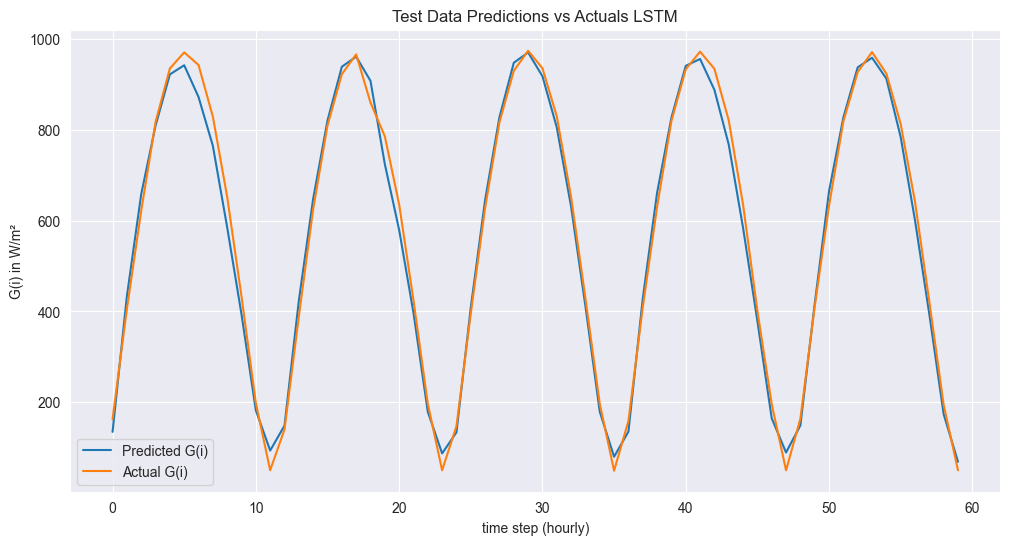

In [76]:
# Access the data_min_ and data_max_ for the first feature
data_min = scaler.data_min_[0]
data_max = scaler.data_max_[0]

Train_prediction = model_LSTM.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Train_Predictions_transformed = Train_prediction * (data_max - data_min) + data_min
y_train1_transformed = y_test1 * (data_max - data_min) + data_min

# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_Predictions_transformed,
    'Actuals': y_train1_transformed
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(train_results['Actuals'][0:60], label="Actual G(i) ")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals LSTM')
plt.legend()
plt.show()


In [77]:
# Define metrics using NumPy
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

# Actual and predicted values

Train_prediction_ERR = model_LSTM.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_prediction_ERR,
    'Actuals': y_test1
})
y_true = train_results['Test Predictions'][0:60].values
y_pred = train_results['Actuals'][0:60]

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)

def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.mean(y_pred - y_true)

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))


348/348 [==============================] - 1s 3ms/step
MAE: 0.022973599696204213
MBA: 0.006718883723975666
RMSE: 0.02715814324065493


In [26]:
def build_optimized_gru_model():
    model = Sequential()
    seq_length=5
    num_features=7
    
    # Input layer
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    
    # First GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Second GRU layer
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(rate=0.1))
    
    # Third GRU layer
    model.add(GRU(units=64))
    model.add(Dropout(rate=0.1))
    
    # Fully connected layer
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.1))
    
    # Output layer
    model.add(Dense(1))  # Linear activation for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Instantiate the model
best_model_gru=build_optimized_gru_model()

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_GRU_Best.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)




In [27]:

# print(best_model.summary())
history_GRU = best_model_gru.fit(
    X_train1, y_train1,
    epochs=200,
    validation_data=(X_val1,y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    batch_size=64,
    verbose=1,
    shuffle=False
)


Epoch 1/200
479/480 [============================>.] - ETA: 0s - loss: 0.0707 - mae: 0.2064
Epoch 1: val_loss improved from inf to 0.04080, saving model to model_optimized_GRU_Best.keras
480/480 [==============================] - 15s 21ms/step - loss: 0.0707 - mae: 0.2063 - val_loss: 0.0408 - val_mae: 0.1471 - lr: 1.0000e-04
Epoch 2/200
480/480 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.1265
Epoch 2: val_loss improved from 0.04080 to 0.02176, saving model to model_optimized_GRU_Best.keras
480/480 [==============================] - 10s 20ms/step - loss: 0.0271 - mae: 0.1265 - val_loss: 0.0218 - val_mae: 0.1001 - lr: 1.0000e-04
Epoch 3/200
479/480 [============================>.] - ETA: 0s - loss: 0.0226 - mae: 0.1146
Epoch 3: val_loss improved from 0.02176 to 0.01830, saving model to model_optimized_GRU_Best.keras
480/480 [==============================] - 10s 21ms/step - loss: 0.0226 - mae: 0.1146 - val_loss: 0.0183 - val_mae: 0.0937 - lr: 1.0000e-04
Epoch 4/200

Epoch 27/200
476/480 [============================>.] - ETA: 0s - loss: 0.0113 - mae: 0.0750
Epoch 27: val_loss improved from 0.00967 to 0.00966, saving model to model_optimized_GRU_Best.keras
480/480 [==============================] - 9s 20ms/step - loss: 0.0112 - mae: 0.0749 - val_loss: 0.0097 - val_mae: 0.0633 - lr: 1.0000e-04
Epoch 28/200
479/480 [============================>.] - ETA: 0s - loss: 0.0112 - mae: 0.0747
Epoch 28: val_loss did not improve from 0.00966
480/480 [==============================] - 11s 22ms/step - loss: 0.0112 - mae: 0.0747 - val_loss: 0.0097 - val_mae: 0.0634 - lr: 1.0000e-04
Epoch 29/200
478/480 [============================>.] - ETA: 0s - loss: 0.0109 - mae: 0.0734
Epoch 29: val_loss did not improve from 0.00966
480/480 [==============================] - 8s 17ms/step - loss: 0.0109 - mae: 0.0733 - val_loss: 0.0098 - val_mae: 0.0642 - lr: 1.0000e-04
Epoch 30/200
480/480 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0736
Epoch 30: val_

480/480 [==============================] - 5s 11ms/step - loss: 0.0105 - mae: 0.0709 - val_loss: 0.0092 - val_mae: 0.0602 - lr: 1.0000e-08
Epoch 53/200
478/480 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0707
Epoch 53: val_loss did not improve from 0.00917
480/480 [==============================] - 6s 12ms/step - loss: 0.0103 - mae: 0.0707 - val_loss: 0.0092 - val_mae: 0.0602 - lr: 1.0000e-09
Epoch 54/200
475/480 [============================>.] - ETA: 0s - loss: 0.0105 - mae: 0.0709
Epoch 54: val_loss did not improve from 0.00917
480/480 [==============================] - 6s 12ms/step - loss: 0.0104 - mae: 0.0708 - val_loss: 0.0092 - val_mae: 0.0602 - lr: 1.0000e-09
Epoch 55/200
480/480 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0707
Epoch 55: val_loss did not improve from 0.00917
480/480 [==============================] - 6s 13ms/step - loss: 0.0104 - mae: 0.0707 - val_loss: 0.0092 - val_mae: 0.0602 - lr: 1.0000e-09
Epoch 56/200
476/480 

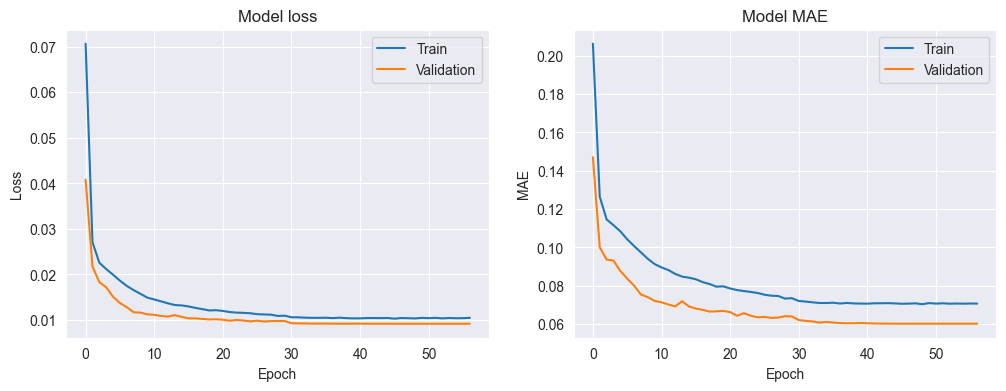

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 68)             15708     
                                                                 
 dropout_8 (Dropout)         (None, 5, 68)             0         
                                                                 
 gru_7 (GRU)                 (None, 5, 68)             28152     
                                                                 
 dropout_9 (Dropout)         (None, 5, 68)             0         
                                                                 
 gru_8 (GRU)                 (None, 64)                25728     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

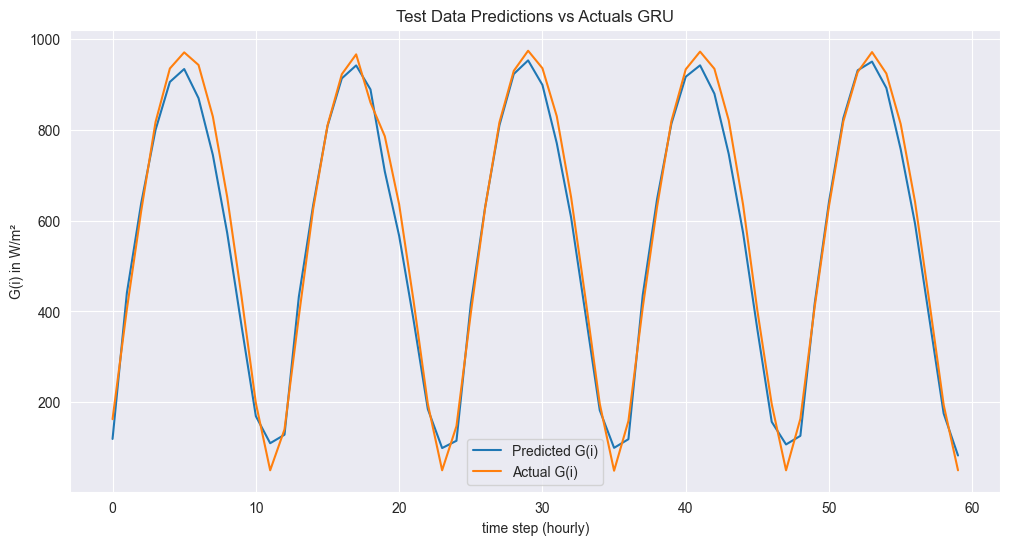

In [78]:
# Access the data_min_ and data_max_ for the first feature
data_min = scaler.data_min_[0]
data_max = scaler.data_max_[0]
best_model_gru = tf.keras.models.load_model('model_optimized_GRU_Best.keras')
print(best_model_gru.summary())

Train_prediction = best_model_gru.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Train_Predictions_transformed = Train_prediction * (data_max - data_min) + data_min
y_train1_transformed = y_test1 * (data_max - data_min) + data_min

# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_Predictions_transformed,
    'Actuals': y_train1_transformed
})

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(train_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(train_results['Actuals'][0:60], label="Actual G(i) ")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals GRU')
plt.legend()
plt.show()

In [79]:
# Define metrics using NumPy
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

# Actual and predicted values

Train_prediction_Testing_GRU = best_model_gru.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_prediction_Testing_GRU,
    'Actuals': y_test1
})
y_true = train_results['Test Predictions'][0:60].values
y_pred = train_results['Actuals'][0:60]

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)

def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))


348/348 [==============================] - 1s 3ms/step
MAE: 0.029894662042970303
MBA: 0.016006400372546362
RMSE: 0.035481925525661644


In [ ]:
\

In [41]:

# ---------------------------------------------
# Model Definition
# ---------------------------------------------

# Replace 'seq_length' and 'num_features' with actual values
seq_length = 5       # For example, using past 24 hours
num_features = 7      # Number of features in your dataset

def build_optimized_rnn_model():
    model = Sequential()
    
    # First RNN layer
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    model.add(SimpleRNN(units=64, return_sequences=True))
    model.add(Dropout(rate=0.2))
    
    # Second RNN layer
    model.add(SimpleRNN(units=64, return_sequences=True))
    model.add(Dropout(rate=0.2))
    
    # Third RNN layer
    model.add(SimpleRNN(units=32))
    model.add(Dropout(rate=0.2))
    
    # Fully connected layer
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.2))
    
    # Output layer
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=Huber(),
        metrics=['mae']
    )
    
    return model

# Instantiate the model
model_RNN = build_optimized_rnn_model()

# ---------------------------------------------
# Callbacks
# ---------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='min'
)

model_checkpoint = ModelCheckpoint(
    'model_optimized_rnn_best.keras',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)

# ---------------------------------------------
# Model Training
# ---------------------------------------------

history_RNN = model_RNN.fit(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    batch_size=64
)


Epoch 1/50
479/480 [============================>.] - ETA: 0s - loss: 0.0388 - mae: 0.2131
Epoch 1: val_loss improved from inf to 0.01300, saving model to model_optimized_rnn_best.keras
480/480 [==============================] - 6s 9ms/step - loss: 0.0388 - mae: 0.2130 - val_loss: 0.0130 - val_mae: 0.1387 - lr: 5.0000e-04
Epoch 2/50
472/480 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.1423
Epoch 2: val_loss improved from 0.01300 to 0.00925, saving model to model_optimized_rnn_best.keras
480/480 [==============================] - 4s 8ms/step - loss: 0.0166 - mae: 0.1421 - val_loss: 0.0092 - val_mae: 0.1142 - lr: 5.0000e-04
Epoch 3/50
476/480 [============================>.] - ETA: 0s - loss: 0.0124 - mae: 0.1227
Epoch 3: val_loss improved from 0.00925 to 0.00661, saving model to model_optimized_rnn_best.keras
480/480 [==============================] - 4s 9ms/step - loss: 0.0124 - mae: 0.1226 - val_loss: 0.0066 - val_mae: 0.0888 - lr: 5.0000e-04
Epoch 4/50
474/480 [

Epoch 28/50
473/480 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0843
Epoch 28: val_loss did not improve from 0.00475
480/480 [==============================] - 5s 9ms/step - loss: 0.0066 - mae: 0.0843 - val_loss: 0.0048 - val_mae: 0.0645 - lr: 5.0000e-06
Epoch 29/50
480/480 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0838
Epoch 29: val_loss did not improve from 0.00475

Epoch 29: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
480/480 [==============================] - 4s 9ms/step - loss: 0.0065 - mae: 0.0838 - val_loss: 0.0048 - val_mae: 0.0651 - lr: 5.0000e-06
Epoch 30/50
480/480 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0840
Epoch 30: val_loss did not improve from 0.00475
480/480 [==============================] - 5s 9ms/step - loss: 0.0065 - mae: 0.0840 - val_loss: 0.0048 - val_mae: 0.0647 - lr: 5.0000e-07
Epoch 31/50
476/480 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0

In [47]:
model_RNN=build_optimized_rnn_model()


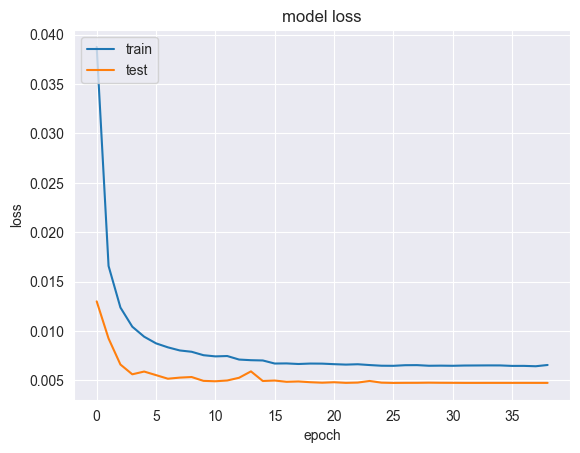

In [42]:
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
# Define metrics using NumPy
def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.abs(np.mean(y_pred - y_true))

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

# Actual and predicted values
model_RNN = tf.keras.models.load_model('model_optimized_rnn_best.keras')
print(model_RNN.summary())

Train_prediction_Testing_RNN = model_RNN.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_prediction_Testing_RNN,
    'Actuals': y_test1
})
y_true = train_results['Test Predictions'][0:60].values
y_pred = train_results['Actuals'][0:60]

# Calculate metrics
mae_value = mae_np(y_true, y_pred)
mba_value = mba_np(y_true, y_pred)
rmse_value = rmse_np(y_true, y_pred)

print("MAE:", mae_value)
print("MBA:", mba_value)
print("RMSE:", rmse_value)

def mae_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mba_np(y_true, y_pred):
    return np.mean(y_pred - y_true)

def rmse_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 5, 64)             4608      
                                                                 
 dropout_20 (Dropout)        (None, 5, 64)             0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 5, 64)             8256      
                                                                 
 dropout_21 (Dropout)        (None, 5, 64)             0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

348/348 [==============================] - 1s 3ms/step


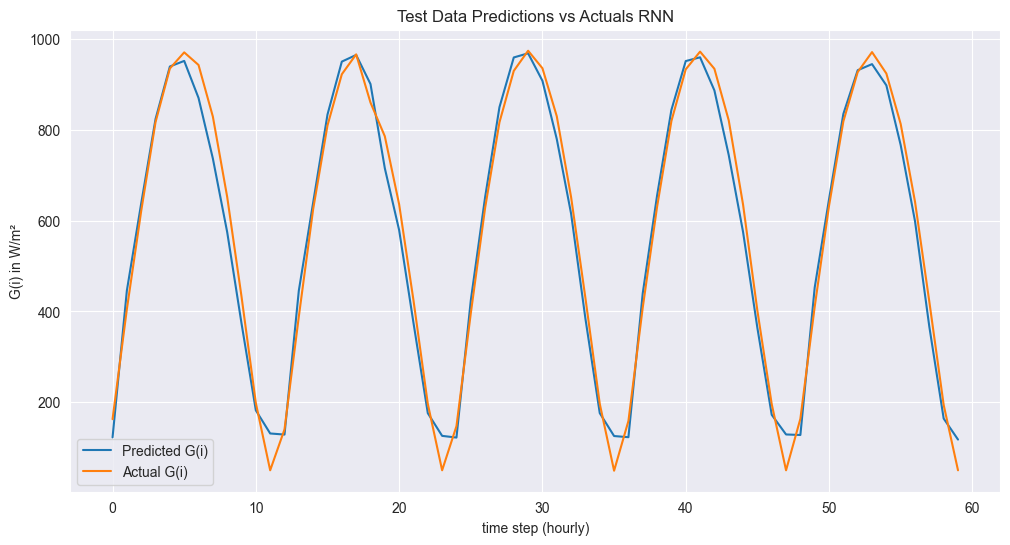

In [81]:
# Access the data_min_ and data_max_ for the first feature
data_min = scaler.data_min_[0]
data_max = scaler.data_max_[0]

Train_prediction_RNN = model_RNN.predict(X_test1).flatten()
Train_prediction_GRU = best_model_gru(X_test1)
Train_prediction_LSTM = model_LSTM.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Train_Predictions_transformed = Train_prediction_RNN * (data_max - data_min) + data_min
y_train1_transformed = y_test1 * (data_max - data_min) + data_min

# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Test Predictions': Train_Predictions_transformed,
    'Actuals': y_train1_transformed
})

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(train_results['Test Predictions'][0:60], label="Predicted G(i)")
plt.plot(train_results['Actuals'][0:60], label="Actual G(i) ")
plt.ylabel('G(i) in W/m²')
plt.xlabel("time step (hourly)")
plt.title('Test Data Predictions vs Actuals RNN')
plt.legend()
plt.show()

348/348 [==============================] - 2s 6ms/step


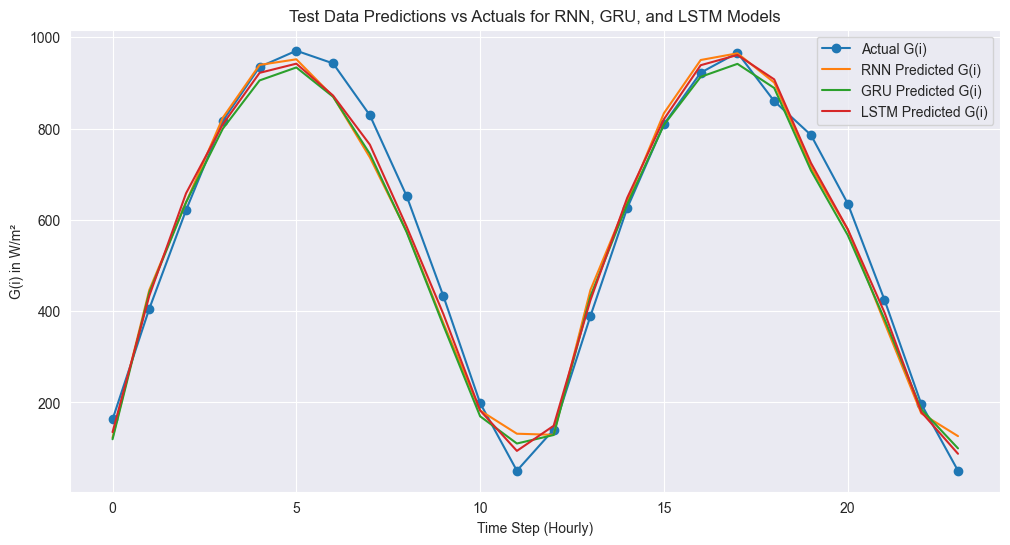

In [122]:
# Access the data_min_ and data_max_ for the first feature
data_min = scaler.data_min_[0]
data_max = scaler.data_max_[0]

# Get predictions from all models
Train_prediction_RNN = model_RNN.predict(X_test1).flatten()
Train_prediction_GRU = best_model_gru.predict(X_test1).flatten()
Train_prediction_LSTM = model_LSTM.predict(X_test1).flatten()

# Manually inverse transform the predictions and actuals
Train_Predictions_RNN_transformed = Train_prediction_RNN * (data_max - data_min) + data_min
Train_Predictions_GRU_transformed = Train_prediction_GRU * (data_max - data_min) + data_min
Train_Predictions_LSTM_transformed = Train_prediction_LSTM * (data_max - data_min) + data_min
y_test1_transformed = y_test1 * (data_max - data_min) + data_min

# Prepare the DataFrame with actual and predicted values
train_results = pd.DataFrame({
    'Actuals': y_test1_transformed,
    'RNN Predictions': Train_Predictions_RNN_transformed,
    'GRU Predictions': Train_Predictions_GRU_transformed,
    'LSTM Predictions': Train_Predictions_LSTM_transformed
})
x_h=0
y_h=24
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_results['Actuals'][x_h:y_h], label="Actual G(i)",marker='o', linestyle='-')
plt.plot(train_results['RNN Predictions'][x_h:y_h], label="RNN Predicted G(i)")
plt.plot(train_results['GRU Predictions'][x_h:y_h], label="GRU Predicted G(i)")
plt.plot(train_results['LSTM Predictions'][x_h:y_h], label="LSTM Predicted G(i)")
plt.ylabel('G(i) in W/m²')
plt.xlabel("Time Step (Hourly)")
plt.title('Test Data Predictions vs Actuals for RNN, GRU, and LSTM Models')
plt.legend()
plt.show()


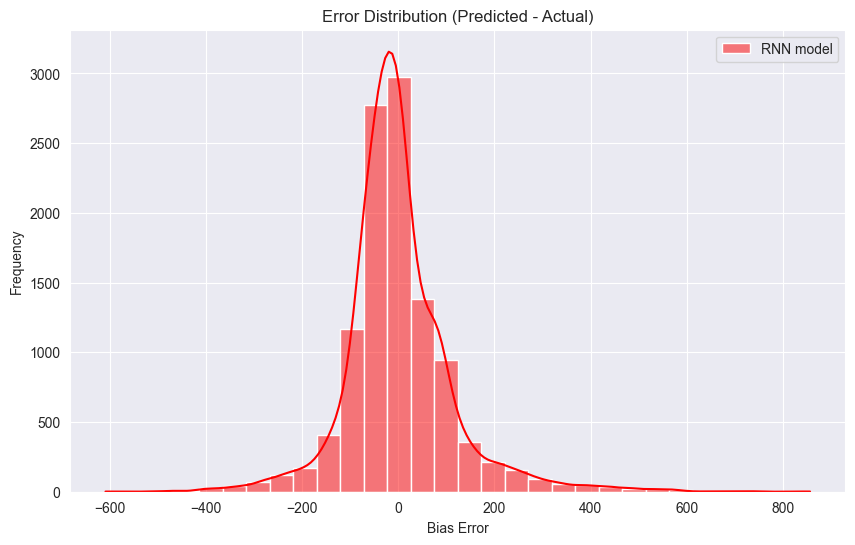

In [109]:
error_RNN = Train_Predictions_RNN_transformed - y_test1_transformed  # Flatten if necessary to make 1D
# Plotting the error distribution with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(error_RNN, kde=True, color="RED", bins=30,label="RNN model")
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Bias Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

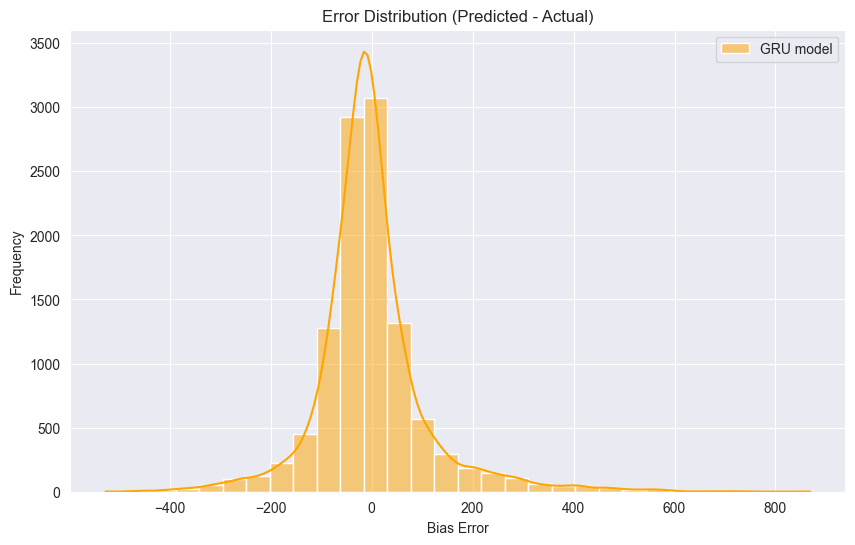

In [110]:
error_GRU = Train_Predictions_GRU_transformed - y_test1_transformed  # Flatten if necessary to make 1D
# Plotting the error distribution with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(error_GRU, kde=True, color="ORANGE", bins=30,label="GRU model")
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Bias Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

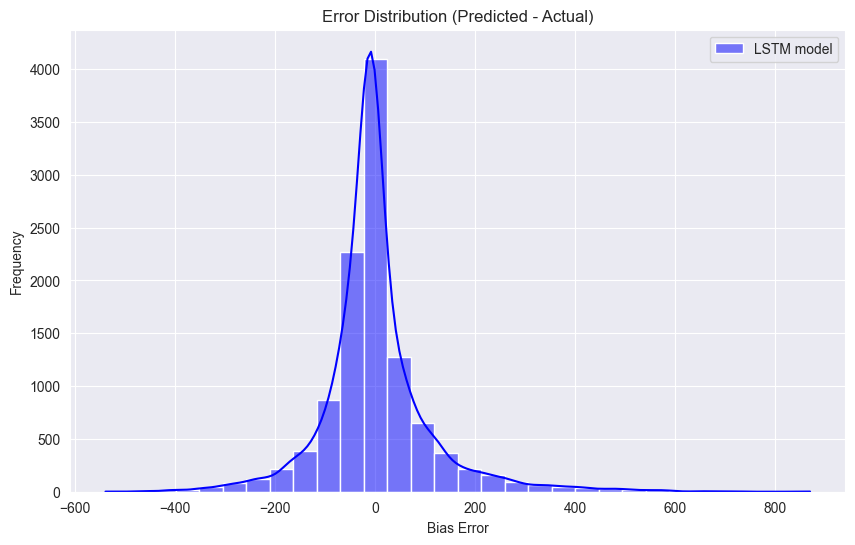

In [111]:
error_LSTM = Train_Predictions_LSTM_transformed - y_test1_transformed  # Flatten if necessary to make 1D
# Plotting the error distribution with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(error_LSTM, kde=True, color="blue", bins=30,label="LSTM model")
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Bias Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()